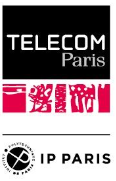
<h3 style='text-align: right'>Kévin MIGADEL</h3>
<h5 style='text-align: right'>03/12/2022</h5>
<h1><center>Projet Final - Vendée Globe 2020-2021</center></h1>

# Projet final du Kit Big Data 2022
Le projet final du Kit Big Data 2022 porte sur les données du **Vendée Globe 2020-2021**.

Le projet se déroule **24 novembre au 4 décembre 2022** date limite pour rendre vos projets respectifs.

Les données du dernier **Vendée Globe** sont disponibles sous la forme de fichiers Excel avec les classements fournis plusieurs fois par jour par les organisateurs de la course. Il y a également une page web avec une fiche technique par voilier qui contient des informations techniques et qu'il est possible de rapprocher des classements.

Il vous appartient de charger les données en Python, de procéder aux préparations nécessaires et d'effectuer les analyses pertinentes de votre choix.

Le rendu sera un notebook Jupyter fourni aux formats ipynb et HTML.

**Barème sur 15 points** :

- Acquisition et chargement des données : 3 points
- Préparation des données : 5 points
- Analyses et story telling : 7 points

**Exemples de traitements et d'analyses** :

1. Acquisition et chargement des données :
   - Acquérir l'ensemble des fichiers Excel des classements via la page de classement.
   - Mettre en place une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
   - Vers la fin de la course le format des fichiers Excel change avec les arrivées des voiliers : il est possible de s'arrêter juste avant.
   - Acquérir les caractéristiques des bateaux.
2. Préparation des données
   - Préparation des données relatives aux classements.
   - Extraction des caractéristiques techniques de chacun des voiliers.
   - Rapprochement des données des voiliers avec celle des classements.
3. Analyses et story telling
   - Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.
   - Impact de la présence d'un *foil* sur le classement et la vitesse des voiliers.
   - Visualisation de la distance parcourue par voilier.
   - Cartes avec les routes d'un ou plusieurs voiliers.
   - Analyses de séries temporelles.
   - Application d'algorithmes statistiques ou de machine learning.
   - etc.

**Sources des données**

- Page web donnant accès aux fichiers Excel des classements du Vendée Globe : https://www.vendeeglobe.org/fr/classement
- Page web avec les fiches techniques des voiliers du Vendée Globe : https://www.vendeeglobe.org/fr/glossaire
- Site web donnant accès à des fichiers avec les formes géométriques des côtes : https://www.naturalearthdata.com/ (ou bien utilisez les librairies **plotly** ou **ipyleaflet** pour produire des cartes)
- etc.

**Questions/Réponses**

Les questions et réponses seront publiées ci-après au fil de l'eau :

1. Qu'est-ce qu'un *foil* ? https://www.vendeeglobe.org/fr/actualites/19755/quels-foils-pour-gagner-le-vendee-globe La présence d'un *foil* est indiqué dans l'attribut "Nombre de dérives" dans les fiches techniques des voiliers.
2. S'agit-il d'un travail individuel ou collectif ? Il s'agit bien d'un travail individuel.
3. Est-il possible de rendre plusieurs notebooks afin de délimiter clairement les différentes étapes du projet ? Tout peut tenir dans un seul notebook, mais pourquoi pas.
4. Y a-t-il une norme pour le code ? Vous pouvez regarder la [PEP8](https://www.python.org/dev/peps/pep-0008/) (voir [Naming Conventions](https://www.python.org/dev/peps/pep-0008/#toc-entry-21) pour les noms de variables et de fonctions), mais le projet n'est particulièrement noté sur ce point.
5. Faut-il créer un unique *DataFrame* mettant à chaque classement d'afficher les caractéristiques des voiliers ou bien peut-on gérer les 2 types de données indépendamment ? C'est à vous de voir en fonction des analyses que vous voulez produire.
6. Peut-on produire des graphiques supplémentaires à ceux proposés ? Oui, vous avez toute latitude pour produire les analyses de votre choix à partir des données.
7. Comment peut-on télécharger les fichier Excel pour ensuite les lire avec **pandas** ? Voir ci-dessous :

```python
from shutil import copyfileobj
from urllib import request

url = 'URL du fichier Excel à télécharger'
filename = 'exemple.xlsx'

with request.urlopen(url) as response, open(filename, 'wb') as out_file:
    copyfileobj(response, out_file)
```
8. Il y a parfois un bug avec **pandas** qui s'appuie à présent sur la librairie **openpyxl** pour lire les fichiers Excel ? Voir le *work-around* ci-dessous avec la librairie **xlwings** qui peut lire les fichiers téléchargés et produire ensuite des fichiers Excel qui sont lisibles par **pandas**. A utiliser de préférence lorsque cela ne fonctionne pas directement avec **pandas** :
```python
import uuid

import xlwings as xw

# lecture/écriture d'un fichier Excel avec xlwings
def save_with_xlwings(file):
    tempfile = './{uuid.uuid1()}.xlsx'
    excel_app = xw.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save(tempfile)
    excel_book.close()
    excel_app.quit()
    return tempfile
```

**Avertissement**

Vous devez publier votre **notebook exécuté aux formats ipynb et HTML** sur votre github **avant le dimanche 4 décembre 2022 à 23h59** et, lorsque c'est fait, **envoyer une notification par email avec le lien du projet** à l'adresse `contact(at)yotta-conseil.fr`. Il n'est pas utile de publier les fichiers de données utilisés.

### Bon projet !


## Import librairies

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from shutil import copyfileobj
from urllib import request
from bs4 import BeautifulSoup

import pandas as pd
import uuid
import xlwings as xw
import requests
import re
import ssl
import os
import unidecode
import numpy as np 
import warnings
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

ssl._create_default_https_context = ssl._create_unverified_context

## 1. Acquisition, chargement des données et prétraitement
#### Acquisition de l'ensemble des fichiers Excel des classements via la page de classement

In [2]:
URL = "https://www.vendeeglobe.org/fr/classement"

def get_classements(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content.decode('utf-8'))
    url_classements = {}
    for option in soup.find_all("option")[1::]:
        filename = re.findall("\"(.*)\"", str(option))[0]
        url_classements[filename] = "https://www.vendeeglobe.org/download-race-data/vendeeglobe_" + filename + ".xlsx"
    return url_classements

In [3]:
#get_classements(URL)

#### Mise en place d'une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.

In [4]:
# lecture/écriture d'un fichier Excel avec xlwings
def save_with_xlwings(file):
    if file == "classements/20210305_080000.xlsx":
        tempfile = file.replace(".xlsx", "_2.xlsx")#f'./{uuid.uuid1()}.xlsx'
    else:
        tempfile = file
    excel_app = xw.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save(tempfile)
    excel_book.close()
    excel_app.quit()
    if file == "classements/20210305_080000.xlsx":
        os.remove(file)
        os.rename(tempfile, file)
    return tempfile

In [5]:
def save_classements_excel():
    url_classement = get_classements(URL)
    for filename, url in url_classement.items():
        with request.urlopen(url) as response, open("classements/"+filename+".xlsx", 'wb') as out_file:
            copyfileobj(response, out_file)
        save_with_xlwings("classements/"+filename)

In [6]:
#save_classements_excel()

#### Traitement des fichiers Excel et obtention d'un classement courant et final pour chaque fichier Excel

In [7]:
def get_new_header(first_row, second_row):
    elements = {}
    for i, e in enumerate(first_row):
        if str(e) != "nan":
            e = str(e).split("\n")[0]
            if str(second_row[i]) != "nan": 
                if e == "Écarts":
                    elements[i+2] = "Au précédent" + ' - ' + e
                elif e == "Sur l'ortho":
                    elements[i] = "Vitesse" + ' - ' + e  + ' (kts)'
                    elements[i+1] = "Distance" + ' - ' + e  + ' (nm)'
                elif e == "Sur le fond":
                    elements[i] = "Vitesse" + ' - ' + e  + ' (kts)'
                    elements[i+1] = "Distance" + ' - ' + e  + ' (nm)'
                elif e == "Depuis 30 minutes":
                    elements[i] = "Cap" + " - " + e + ' (°)'
                    elements[i+1] = "Vitesse" + ' - ' + e + ' (kts)'
                    elements[i+2] = "VMG" + ' - ' + e + ' (kts)'
                    elements[i+3] = "Distance" + ' - ' + e  + ' (nm)'
                elif e == "Depuis le dernier classement":
                    elements[i] = "Cap" + " - " + e + ' (°)'
                    elements[i+1] = "Vitesse" + ' - ' + e + ' (kts)'
                    elements[i+2] = "VMG" + ' - ' + e + ' (kts)'
                    elements[i+3] = "Distance" + ' - ' + e  + ' (nm)'
                elif e == "Depuis 24 heures":
                    elements[i] = "Cap" + " - " + e + ' (°)'
                    elements[i+1] = "Vitesse" + ' - ' + e + ' (kts)'
                    elements[i+2] = "VMG" + ' - ' + e + ' (kts)'
                    elements[i+3] = "Distance" + ' - ' + e  + ' (nm)'
            else:
                if e == 'DTF' or e == 'DTL':
                    elements[i] = e + ' (nm)'
                elif e == '►':
                    elements[i] = e + ' (%)'
                else:
                    elements[i] = e
    return elements

In [8]:
def preprocessing_current_classement(current_classement):
    current_classement["Nat. / Voile"] = current_classement["Nat. / Voile"].str.replace("\n","")
    current_classement["Nat. / Voile"] = current_classement["Nat. / Voile"].str.replace("FRFRA","FRA")
    
    current_classement["Skipper / Bateau"] = current_classement["Skipper / Bateau"].str.replace("\n"," / ")
    current_classement["Skipper / Bateau"] = current_classement["Skipper / Bateau"].str.title()
    skippers = np.array([unidecode.unidecode(skipper, "utf-8") for skipper in current_classement["Skipper / Bateau"]])
    current_classement["Skipper / Bateau"] = skippers
    
    current_classement.pop('Heure FR')
    
    current_classement['VMG - Depuis 24 heures (kts)'] = current_classement['VMG - Depuis 24 heures (kts)'].str.replace(' kts','')
    current_classement['VMG - Depuis 24 heures (kts)'] = current_classement['VMG - Depuis 24 heures (kts)'].astype(float)
    
    current_classement['VMG - Depuis 30 minutes (kts)'] = current_classement['VMG - Depuis 30 minutes (kts)'].str.replace(' kts','')
    current_classement['VMG - Depuis 30 minutes (kts)'] = current_classement['VMG - Depuis 30 minutes (kts)'].astype(float)
    
    current_classement['VMG - Depuis le dernier classement (kts)'] = current_classement['VMG - Depuis le dernier classement (kts)'].str.replace(' kts','')
    current_classement['VMG - Depuis le dernier classement (kts)'] = current_classement['VMG - Depuis le dernier classement (kts)'].astype(float)
    
    current_classement['Cap - Depuis 24 heures (°)'] = current_classement['Cap - Depuis 24 heures (°)'].str.replace('°','')
    current_classement['Cap - Depuis 24 heures (°)'] = current_classement['Cap - Depuis 24 heures (°)'].astype(float)
    
    current_classement['Cap - Depuis 30 minutes (°)'] = current_classement['Cap - Depuis 30 minutes (°)'].str.replace('°','')
    current_classement['Cap - Depuis 30 minutes (°)'] = current_classement['Cap - Depuis 30 minutes (°)'].astype(float)
    
    current_classement['Cap - Depuis le dernier classement (°)'] = current_classement['Cap - Depuis le dernier classement (°)'].str.replace('°','')
    current_classement['Cap - Depuis le dernier classement (°)'] = current_classement['Cap - Depuis le dernier classement (°)'].astype(float)
    
    current_classement['Vitesse - Depuis 24 heures (kts)'] = current_classement['Vitesse - Depuis 24 heures (kts)'].str.replace(' kts','')
    current_classement['Vitesse - Depuis 24 heures (kts)'] = current_classement['Vitesse - Depuis 24 heures (kts)'].astype(float)
    
    current_classement['Vitesse - Depuis 30 minutes (kts)'] = current_classement['Vitesse - Depuis 30 minutes (kts)'].str.replace(' kts','')
    current_classement['Vitesse - Depuis 30 minutes (kts)'] = current_classement['Vitesse - Depuis 30 minutes (kts)'].astype(float)
    
    current_classement['Vitesse - Depuis le dernier classement (kts)'] = current_classement['Vitesse - Depuis le dernier classement (kts)'].str.replace(' kts','')
    current_classement['Vitesse - Depuis le dernier classement (kts)'] = current_classement['Vitesse - Depuis le dernier classement (kts)'].astype(float)
    
    current_classement['Distance - Depuis 24 heures (nm)'] = current_classement['Distance - Depuis 24 heures (nm)'].str.replace(' nm','')
    current_classement['Distance - Depuis 24 heures (nm)'] = current_classement['Distance - Depuis 24 heures (nm)'].astype(float)
    
    current_classement['Distance - Depuis 30 minutes (nm)'] = current_classement['Distance - Depuis 30 minutes (nm)'].str.replace(' nm','')
    current_classement['Distance - Depuis 30 minutes (nm)'] = current_classement['Distance - Depuis 30 minutes (nm)'].astype(float)
    
    current_classement['Distance - Depuis le dernier classement (nm)'] = current_classement['Distance - Depuis le dernier classement (nm)'].str.replace(' nm','')
    current_classement['Distance - Depuis le dernier classement (nm)'] = current_classement['Distance - Depuis le dernier classement (nm)'].astype(float)
    
    current_classement['DTF (nm)'] = current_classement['DTF (nm)'].str.replace(' nm','') 
    current_classement['DTF (nm)'] = current_classement['DTF (nm)'].astype(float)
    
    current_classement['DTL (nm)'] = current_classement['DTL (nm)'].str.replace(' nm','') 
    current_classement['DTL (nm)'] = current_classement['DTL (nm)'].astype(float)
    
    return current_classement


In [9]:
def preprocessing_final_classement(final_classement):
    
    final_classement["Nat. / Voile"] = final_classement["Nat. / Voile"].str.replace("\n","")
    final_classement["Nat. / Voile"] = final_classement["Nat. / Voile"].str.replace("FRFRA","FRA")
    
    final_classement["Rang"] = final_classement["Rang"].str.replace("\nARV","")
    
    final_classement["Skipper / Bateau"] = final_classement["Skipper / Bateau"].str.replace("\n"," / ")
    final_classement["Skipper / Bateau"] = final_classement["Skipper / Bateau"].str.title()
    skippers = np.array([unidecode.unidecode(skipper, "utf-8") for skipper in final_classement["Skipper / Bateau"]])
    final_classement["Skipper / Bateau"] = skippers
    
    final_classement["Temps de course"] = final_classement["Temps de course"].str.replace(r"\n.*","") 
    
    final_classement['► (%)'] = final_classement['► (%)'].str.replace('%','')
    final_classement['► (%)'] = final_classement['► (%)'].astype(float)
    
    final_classement['Vitesse - Sur l\'ortho (kts)'] = final_classement['Vitesse - Sur l\'ortho (kts)'].str.replace(' kts', '')
    final_classement['Vitesse - Sur l\'ortho (kts)'] = final_classement['Vitesse - Sur l\'ortho (kts)'].astype(float)
    
    final_classement['Vitesse - Sur le fond (kts)'] = final_classement['Vitesse - Sur le fond (kts)'].str.replace(' kts', '')
    final_classement['Vitesse - Sur le fond (kts)'] = final_classement['Vitesse - Sur le fond (kts)'].astype(float)
    
    final_classement['Distance - Sur l\'ortho (nm)'] = final_classement['Distance - Sur l\'ortho (nm)'].str.replace(' nm', '')
    final_classement['Distance - Sur l\'ortho (nm)'] = final_classement['Distance - Sur l\'ortho (nm)'].astype(float)
    
    final_classement['Distance - Sur le fond (nm)'] = final_classement['Distance - Sur le fond (nm)'].str.replace(' nm', '')
    final_classement['Distance - Sur le fond (nm)'] = final_classement['Distance - Sur le fond (nm)'].astype(float)
    
    return final_classement


In [10]:
def get_current_and_final_classement(classement):
    
    #Delete title of the classement
    classement = pd.DataFrame(classement.values[2:-4])
    
    #Get the first and second rows to merge them to a unique header
    first_row = classement.iloc[0]
    second_row = classement.iloc[1]
    elements = get_new_header(first_row, second_row)
    second_row.update(pd.Series(list(elements.values()), index=list(elements.keys())))
    second_row = second_row.str.split("\n").str[0]
    classement = pd.DataFrame(classement.values[2:], columns=second_row)
    
    
    # Here, we detect if a skipper is arrived to separate the current_classement and the final_classement
    # To do that, we check if the term "ARV" exist in the columns "Rang:Rank"
    rang = classement["Rang"]
    index_separation = 0
    next_ele_index = 1
    for ele, next_ele in zip(rang, rang[1::]):
        if ("ARV" in str(ele)) ^ ("RET" in str(ele)) :
            if ("ARV" not in str(next_ele)) and ("RET" not in str(next_ele)):
                index_separation = rang[rang==next_ele].index[0]
                break
            if next_ele_index == rang.last_valid_index():
                index_separation = next_ele_index + 1
                break
            next_ele_index = next_ele_index + 1
    
    # If no skipper finally arrived, the index_separation is equal to 0
    # So there is no final_classement and the current_classement is classement
    # Otherwise, the final classement contains all the rows until the index_separation
    # and the current_classement all the next rows
    if index_separation == 0:
        final_classement = pd.DataFrame()
        current_classement = classement
    else:
        final_classement = classement.iloc[:index_separation]
        current_classement = classement.iloc[index_separation:]
    
    if current_classement.shape[0] != 0 and index_separation != 0:
        # The we have to remake the header of the current_classement before to return
        # the final_classement and the current_classement
        # We merge the old_header and the the new header, here contains in first_rows
        first_row = current_classement.iloc[0]
        old_headers = current_classement.iloc[1]
        elements = get_new_header(first_row, old_headers)
        
        # We reset the names of the columns to update the new_header
        current_classement.columns = range(current_classement.columns.size)
        current_classement.T.reset_index(drop=True).T
        current_classement.columns = range(current_classement.shape[1])
        new_header = current_classement.iloc[1]

        new_header.update(pd.Series(list(elements.values()), index=list(elements.keys())))
        new_header = new_header.str.split("\n").str[0]
        
        # Depending of the presence of final_classement, we trunk the two first rows of the 
        # current_classement
        current_classement = pd.DataFrame(current_classement.values[2:], columns=new_header)
    
    if current_classement.shape[0] != 0:
        # Preprocessing of data for current_classement
        current_classement = preprocessing_current_classement(current_classement)
        latitude = []
        for lat in current_classement['Latitude']:
            if str(lat) != "nan":
                deg, minutes, seconds, direction =  re.split('[°\.\']', str(lat))
                latitude.append((float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1))
            else:
                latitude.append(float(0))
        current_classement["Latitude"] = np.array(latitude)
        
        longitude = []
        for long in current_classement['Longitude']:
            if str(long) != "nan":
                deg, minutes, seconds, direction =  re.split('[°\.\']', str(long))
                longitude.append((float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1))
            else:
                longitude.append(float(0))
        current_classement["Longitude"] = np.array(longitude)
    
    current_classement = current_classement[current_classement.columns.dropna()]
    current_classement.columns.names = ['']

    if final_classement.empty == False:
        # Merging some columns where the values are in different column of their corresponding columns name
        final_classement.iloc[:,4] = final_classement.iloc[:,7]
        final_classement.iloc[:,12] = final_classement.iloc[:,13]
        final_classement.iloc[:,14] = final_classement.iloc[:,15]

        # Deleting the columns with the name NaN
        final_classement = final_classement[final_classement.columns.dropna()]

        # Delete the name of columns index
        final_classement.columns.names = ['']

        # Preprocessing of data for final_classement
        final_classement = preprocessing_final_classement(final_classement)
    
    return current_classement, final_classement

#### Création d'un dataframe comprenant l'ensemble des classements durant la course

In [11]:
def create_current_classement_dataframe():
    if os.path.exists('classement') == False:
        os.mkdir("classement")
    date = []
    df = pd.DataFrame()
    for file_idx, txt_file in enumerate(os.listdir("classements/")):
        if ".xlsx" in txt_file and txt_file != "20201108_120200.xlsx":
            classement = pd.read_excel("classements/"+txt_file)
            current_classement, final_classement = get_current_and_final_classement(classement)
            for i in range(len(current_classement)):
                date.append(txt_file.split(".")[0])
            if current_classement.empty == False:
                df = pd.concat([df, current_classement])

    d = [datetime.datetime(int(i[0:4]), int(i[4:6]), int(i[6:8]), int(i[9:11]), int(i[11:13]), int(i[13:15])) for i in date[:len(df)]]
    df.insert(0, 'Date', pd.to_datetime(d))
    latitude = []
    for idx, lat in enumerate(df['Latitude']):
        if lat == float(0):
            if len(latitude) == 0:
                latitude.append(46.422500)	
            else:
                latitude.append(latitude[-1])
        else:
            latitude.append(lat)
    df["Latitude"] = np.array(latitude)

    longitude = []
    for idx, long in enumerate(df['Longitude']):
        if long == float(0):
            if len(longitude) == 0:
                longitude.append(-1.829167)
            else:
                longitude.append(longitude[-1])
        else:
            longitude.append(long)
    df["Longitude"] = np.array(longitude)
    df.to_pickle('classement/current_classement.pkl')

In [12]:
#create_current_classement_dataframe()

#### Création d'un dataframe comprenant l'ensemble des classements d'arrivée la course

In [13]:
def create_final_classement_dataframe():
    if os.path.exists('classement') == False:
        os.mkdir("classement")
    date = []
    df = pd.DataFrame()
    for file_idx, txt_file in enumerate(os.listdir("classements/")):
        if ".xlsx" in txt_file and txt_file != "20201108_120200.xlsx":
            classement = pd.read_excel("classements/"+txt_file)
            current_classement, final_classement = get_current_and_final_classement(classement)
            for i in range(len(final_classement)):
                date.append(txt_file.split(".")[0])
            if final_classement.empty == False:
                df = pd.concat([df, final_classement])

    d = [datetime.datetime(int(i[0:4]), int(i[4:6]), int(i[6:8]), int(i[9:11]), int(i[11:13]), int(i[13:15])) for i in date[:len(df)]]
    df.insert(0, 'Date', pd.to_datetime(d))
    df.to_pickle('classement/final_classement.pkl')

In [14]:
#create_final_classement_dataframe()

#### Create a dataframe for each skipper

In [15]:
def create_skipper_dataframe():
    if os.path.exists('skippers') == False:
        os.mkdir("skippers")
    for skipper_name in boats_features.keys():
        date = []
        df = pd.DataFrame()
        for file_idx, txt_file in enumerate(os.listdir("classements/")):
            if ".xlsx" in txt_file and txt_file != "20201108_120200.xlsx":
                classement = pd.read_excel("classements/"+txt_file)
                date.append(txt_file.split(".")[0])
                current_classement, final_classement = get_current_and_final_classement(classement)
                if current_classement.empty == False:
                    df = pd.concat([df, current_classement.loc[current_classement['Skipper / Bateau'].str.contains(skipper_name)]])

        d = [datetime.datetime(int(i[0:4]), int(i[4:6]), int(i[6:8]), int(i[9:11]), int(i[11:13]), int(i[13:15])) for i in date[:len(df)]]
        df.insert(0, 'Date', pd.to_datetime(d))
        latitude = []
        for idx, lat in enumerate(df['Latitude']):
            if lat == float(0):
                if len(latitude) == 0:
                    latitude.append(46.422500)	
                else:
                    latitude.append(latitude[-1])
            else:
                latitude.append(lat)
        df["Latitude"] = np.array(latitude)

        longitude = []
        for idx, long in enumerate(df['Longitude']):
            if long == float(0):
                if len(longitude) == 0:
                    longitude.append(-1.829167)
                else:
                    longitude.append(longitude[-1])
            else:
                longitude.append(long)
        df["Longitude"] = np.array(longitude)
        df.to_pickle('skippers/'+skipper_name + '.pkl')

In [16]:
#create_skipper_dataframe()

#### Acquérir les caractéristiques des bateaux

In [17]:
URL_glossaire = "https://www.vendeeglobe.org/fr/glossaire"

def get_boat_characteristics(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content.decode('utf-8'))
    boats_list = {}
    database = []
    for boat in soup.find_all("div", attrs={'class': 'sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6'}):
        boat_dict = {}
        
        boat_name = boat.find("h3", attrs={'class': 'boats-list__boat-name'}).text
        skipper_name = boat.find("span", attrs={'class': 'boats-list__skipper-name'}).text
        skipper_name = unidecode.unidecode(skipper_name, "utf-8")
        boat_name = unidecode.unidecode(boat_name, "utf-8")        
        
        if boat_name[-1:] == " ":
            boat_name = boat_name[:-1]
            
        if boat_name == "":
            boat_name = "Bateau de " + skipper_name
        
        boat_dict["Nom du bateau"] = boat_name.title()
        
        for li in boat.find_all('li'):
            if li.text.count(":") == 2:
                features_name, features_values = li.text.split(" : ")[:2]
                features_values = features_values.split(" / ")[0]
            else:
                features_name, features_values = li.text.split(" : ")[:2]
            boat_dict[features_name] = features_values
        
        skipper_name = skipper_name.replace("  ", " ")
        if skipper_name == "Sam DAVIES":
            skipper_name = "Samantha DAVIES"
        key = skipper_name.title()
        
        boats_list[key] = boat_dict
        
    return boats_list

In [18]:
boats_features = get_boat_characteristics(URL_glossaire)

## 2. Analyses et story telling

### Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.

#### Corrélation entre le rang et la vitesse sur le fond

In [92]:
df = pd.read_pickle('classement/final_classement.pkl')
df = df[df['Rang'] != 'RET']
df = df[df['Rang'] != 'NL']
df = df[['Rang', 'Vitesse - Sur l\'ortho (kts)', 'Distance - Sur l\'ortho (nm)', 'Vitesse - Sur le fond (kts)', 'Distance - Sur le fond (nm)']]
df

Rang  Vitesse - Sur l'ortho (kts)  Distance - Sur l'ortho (nm)  \
0     1                         12.6                      24355.0   
0     1                         12.6                      24365.7   
1     2                         12.6                      24365.7   
2     3                         12.6                      24365.7   
0     1                         12.6                      24365.7   
..  ...                          ...                          ...   
20   21                         10.2                      24365.7   
21   22                         10.0                      24365.7   
22   23                          9.8                      24365.7   
23   24                          9.1                      24365.7   
24   25                          8.7                      24365.7   

    Vitesse - Sur le fond (kts)  Distance - Sur le fond (nm)  
0                          15.1                      29135.0  
0                          14.8                      28583.8  
1                          15.1                      29135.0  
2                          14.8                      28650.0  
0                          14.8                      28583.8  
..                          ...                          ...  
20                         11.7                      28137.8  
21                         11.4                      27656.2  
22                         11.7                      29115.7  
23                         10.5                      28170.7  
24                         10.4                      29122.0  

[3931 rows x 5 columns]

Corrélation entre le rang et le foil est de : -0.9483
On observe une relation quasiment linéaire entre le rang d'un skipper et sa vitesse sur fond.


Text(0.5, 1.0, 'Rang du skipper en fonction de sa vitesse sur le fond (kts)')

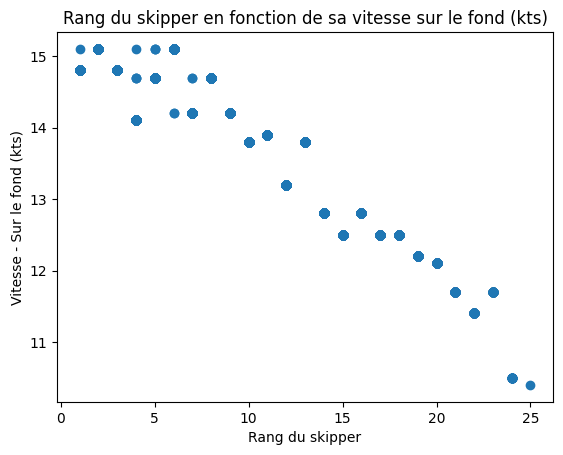

In [93]:
df['Rang'] = df['Rang'].astype(float)

print("Corrélation entre le rang et le foil est de :", round(df['Rang'].corr(df['Vitesse - Sur le fond (kts)']), 4))
print("On observe une relation quasiment linéaire entre le rang d'un skipper et sa vitesse sur fond.")

plt.scatter(df['Rang'], df['Vitesse - Sur le fond (kts)'])
plt.xlabel('Rang du skipper')
plt.ylabel('Vitesse - Sur le fond (kts)')
plt.title('Rang du skipper en fonction de sa vitesse sur le fond (kts)')

#### Régression linéaire entre le rang (Y) et la vitesse sur le fond + la vitesse sur l'ortho (X)

On observe que la RMSE est de seulement : 1.8228
De plus, on observe à l'aide du scatter plot une relation quasiment linéaire entre la prédiction de notre modèle et le véritable rang du skipper.


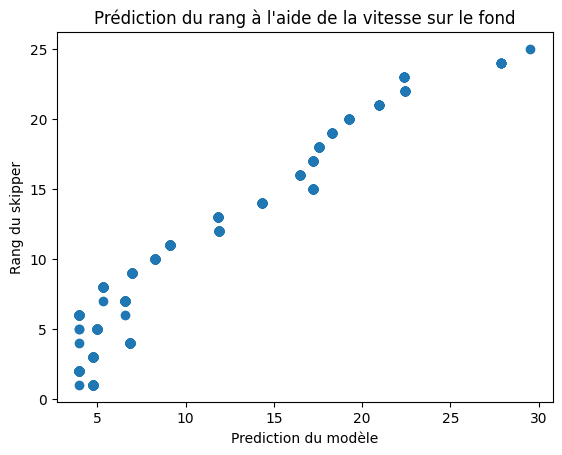

In [94]:
X = df[['Vitesse - Sur le fond (kts)', 'Vitesse - Sur l\'ortho (kts)']]
Y = df['Rang']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

lm = LinearRegression().fit(X_train, Y_train)

prediction = lm.predict(X_test)

plt.scatter(prediction, Y_test)
plt.xlabel("Prediction du modèle")
plt.ylabel("Rang du skipper")
plt.title("Prédiction du rang à l'aide de la vitesse sur le fond")
print('On observe que la RMSE est de seulement :', round(np.sqrt(metrics.mean_squared_error(Y_test, prediction)), 4))

print("De plus, on observe à l'aide du scatter plot une relation quasiment linéaire entre la prédiction de notre modèle et le véritable rang du skipper.")

### Impact de la présence d'un foil sur le classement et la vitesse des voiliers.
#### On ajoute la colonne 'Foil' au Dataframe et on ne prend pas en compte les personnes qui ont abandonnées

In [22]:
df_foil = pd.read_pickle('classement/final_classement.pkl')
df_foil = df_foil[df_foil['Rang'] != 'RET']
df_foil = df_foil[df_foil['Rang'] != 'NL']
skippers = df_foil['Skipper / Bateau']
foils = []
for skipper in skippers:
    if 'Nombre de dérives' in boats_features[skipper.split(" / ")[0]]:
        if 'foil' in boats_features[skipper.split(" / ")[0]]['Nombre de dérives']:
            foils.append(1)
        else:
            foils.append(0)
df_foil.insert(2, 'Foil', foils)
df_foil = df_foil[['Rang', 'Foil', 'Vitesse - Sur l\'ortho (kts)', 'Distance - Sur l\'ortho (nm)', 'Vitesse - Sur le fond (kts)', 'Distance - Sur le fond (nm)']]
df_foil

Rang  Foil  Vitesse - Sur l'ortho (kts)  Distance - Sur l'ortho (nm)  \
0     1     1                         12.6                      24355.0   
0     1     1                         12.6                      24365.7   
1     2     1                         12.6                      24365.7   
2     3     1                         12.6                      24365.7   
0     1     1                         12.6                      24365.7   
..  ...   ...                          ...                          ...   
20   21     0                         10.2                      24365.7   
21   22     0                         10.0                      24365.7   
22   23     0                          9.8                      24365.7   
23   24     0                          9.1                      24365.7   
24   25     0                          8.7                      24365.7   

    Vitesse - Sur le fond (kts)  Distance - Sur le fond (nm)  
0                          15.1                      29135.0  
0                          14.8                      28583.8  
1                          15.1                      29135.0  
2                          14.8                      28650.0  
0                          14.8                      28583.8  
..                          ...                          ...  
20                         11.7                      28137.8  
21                         11.4                      27656.2  
22                         11.7                      29115.7  
23                         10.5                      28170.7  
24                         10.4                      29122.0  

[3931 rows x 6 columns]

On observe de manière générale que les voiliers équipé d'un foil ont tendance a avoir une vitesse de fond plus importante et un meilleur rang que les autres voiliers.


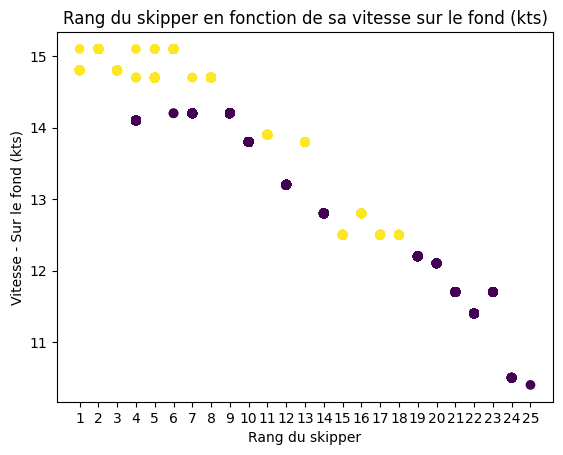

In [23]:
plt.scatter(df_foil['Rang'], df_foil['Vitesse - Sur le fond (kts)'], c=df_foil['Foil'])
plt.xlabel('Rang du skipper')
plt.ylabel('Vitesse - Sur le fond (kts)')
plt.title('Rang du skipper en fonction de sa vitesse sur le fond (kts)')
print("On observe de manière générale que les voiliers équipé d'un foil ont tendance a avoir une vitesse de fond plus importante et un meilleur rang que les autres voiliers.")

### Visualisation de la distance parcourue par voilier.

Text(0.5, 1.0, 'Distance parcouru par les voiliers utilisant le foil')

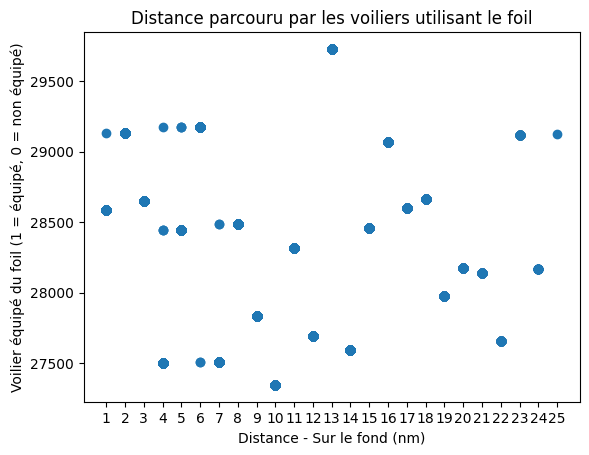

In [24]:
plt.scatter(df_foil['Rang'], df_foil['Distance - Sur le fond (nm)'])
plt.xlabel('Distance - Sur le fond (nm)')
plt.ylabel('Voilier équipé du foil (1 = équipé, 0 = non équipé)')
plt.title('Distance parcouru par les voiliers utilisant le foil')

Text(0.5, 1.0, 'Distance parcouru par les voiliers utilisant le foil')

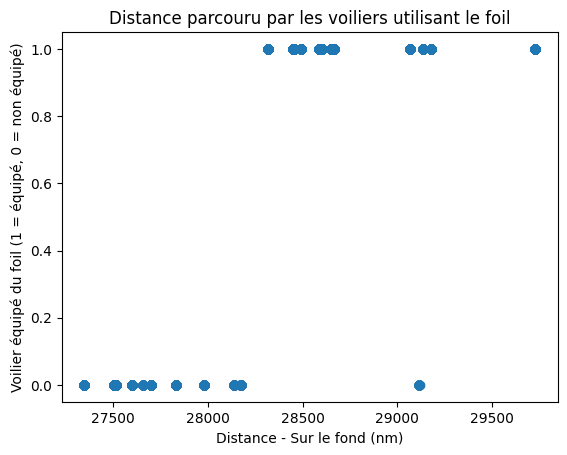

In [25]:
plt.scatter(df_foil['Distance - Sur le fond (nm)'], df_foil['Foil'])
plt.xlabel('Distance - Sur le fond (nm)')
plt.ylabel('Voilier équipé du foil (1 = équipé, 0 = non équipé)')
plt.title('Distance parcouru par les voiliers utilisant le foil')

In [26]:
print("Corrélation entre la distance sur le fond et le foil est de :", round(df_foil['Distance - Sur le fond (nm)'].corr(df_foil['Foil']), 4))
print("On observe que les voiliers équipé d'un foil ont tendance à parcourir de plus grande distance de fond.")

Corrélation entre la distance sur le fond et le foil est de : 0.7871
On observe que les voiliers équipé d'un foil ont tendance à parcourir de plus grande distance de fond.


### Cartes avec les routes d'un ou plusieurs voiliers.

#### Show the path of each skipper

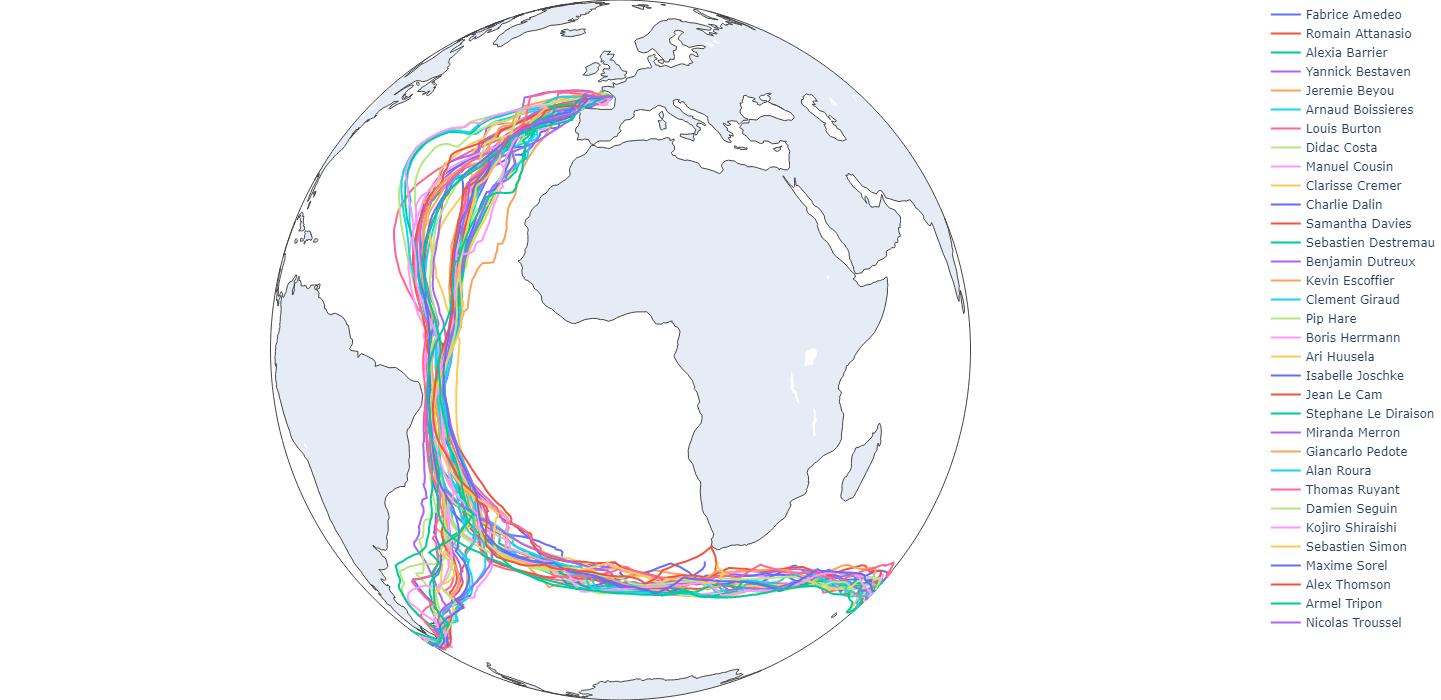

In [77]:
datas = []
for skipper_name in boats_features.keys():
    df = pd.read_pickle('skippers/'+ skipper_name +'.pkl')
    datas.append(go.Scattergeo(
        lat = list(df['Latitude']), 
        lon = list(df['Longitude']), 
        mode = 'lines', 
        line = dict(width = 2), 
        text = list(df['Date']),
        name = skipper_name
    ))

fig = go.Figure(data=datas)
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Analyses de séries temporelles
#### Observation du rang des skippers au fur et à mesure de la course

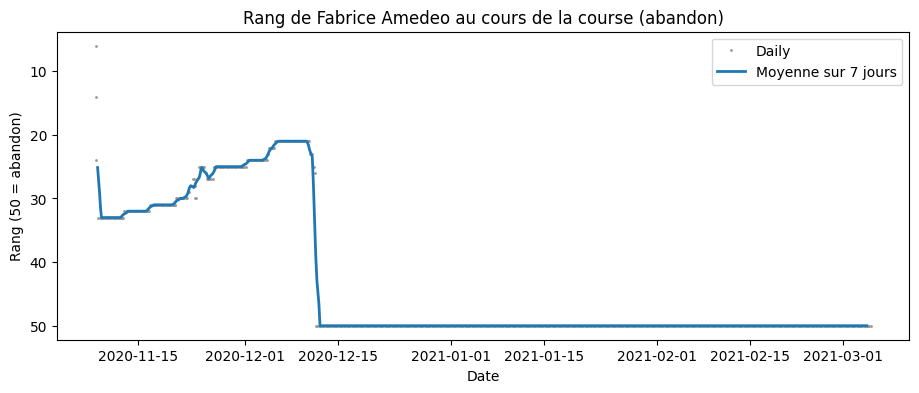

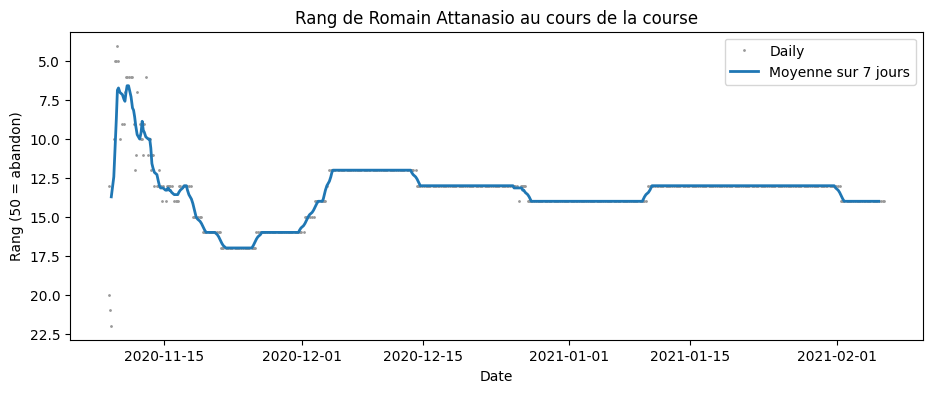

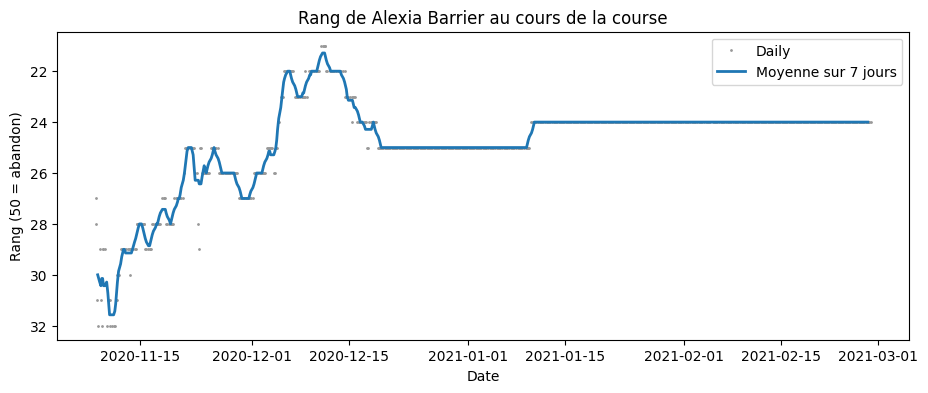

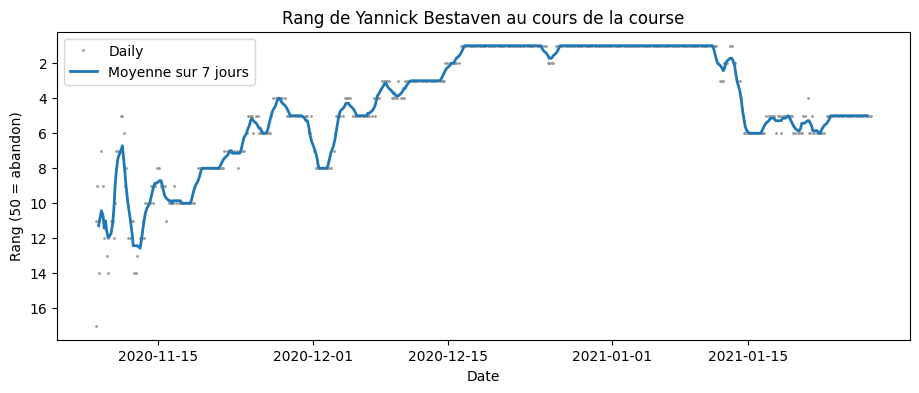

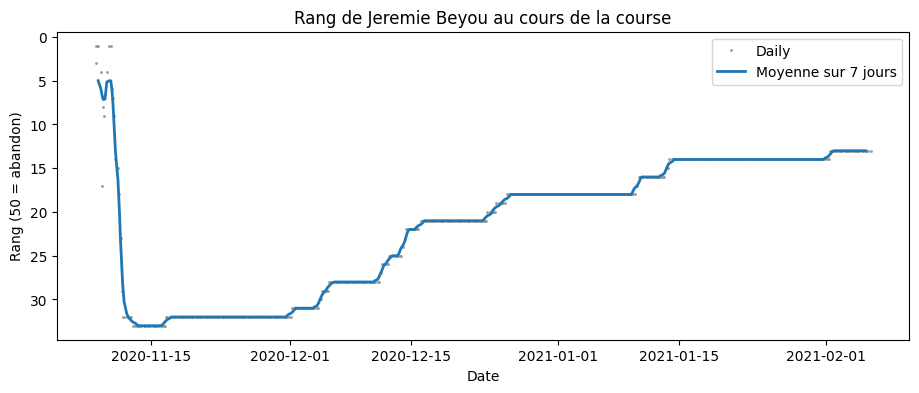

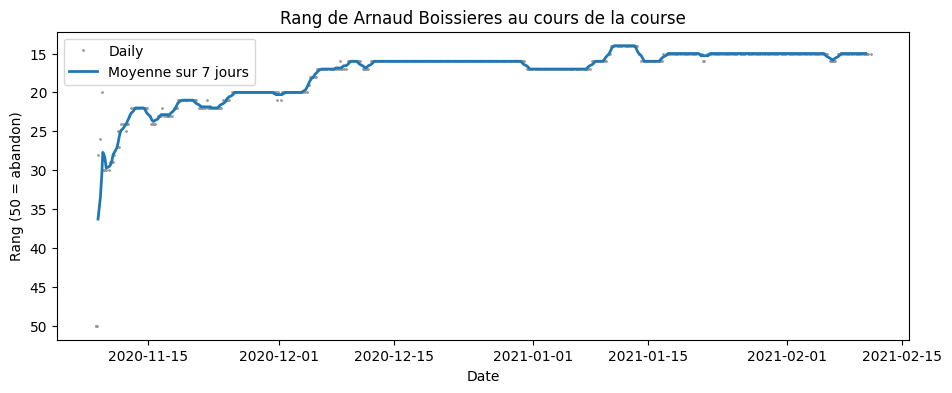

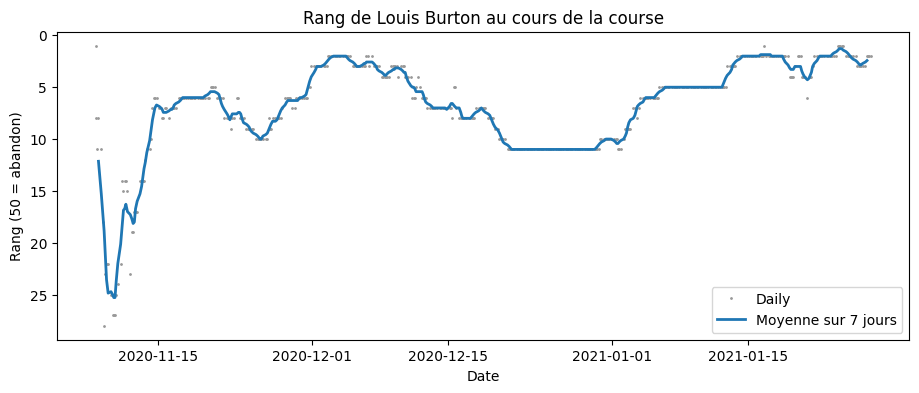

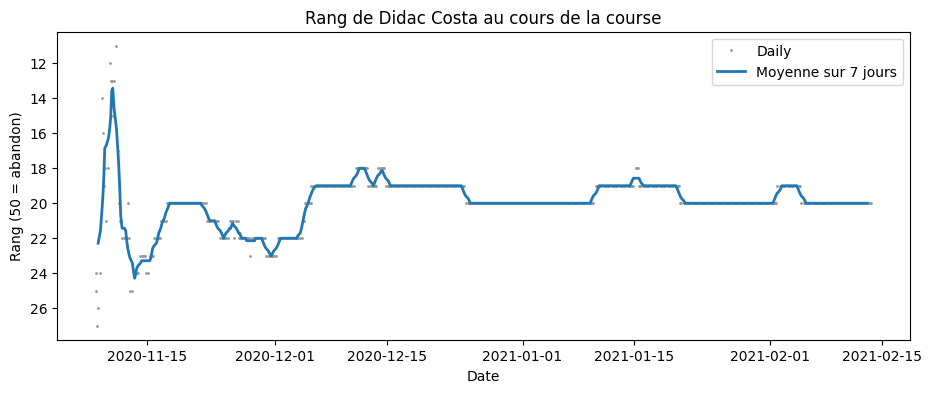

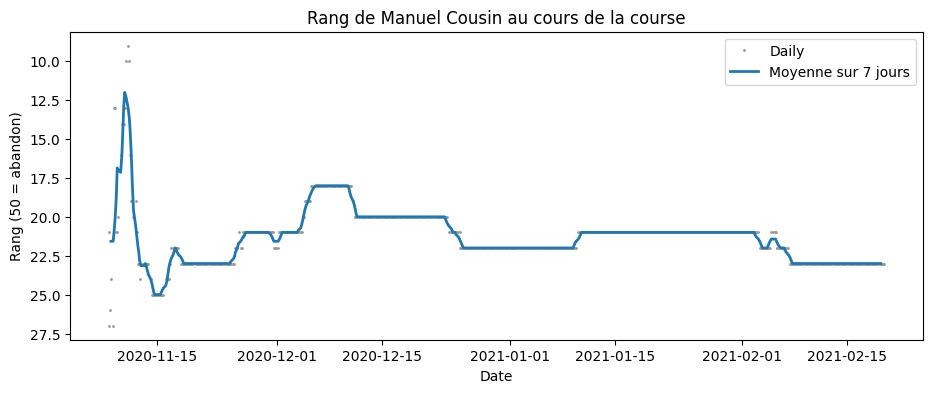

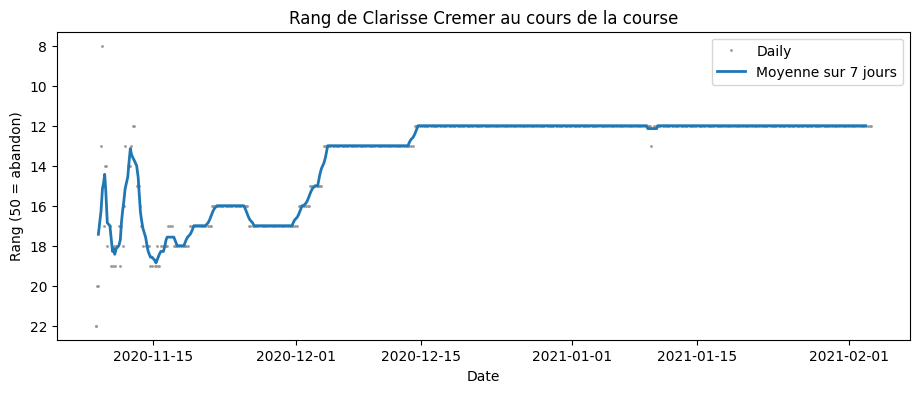

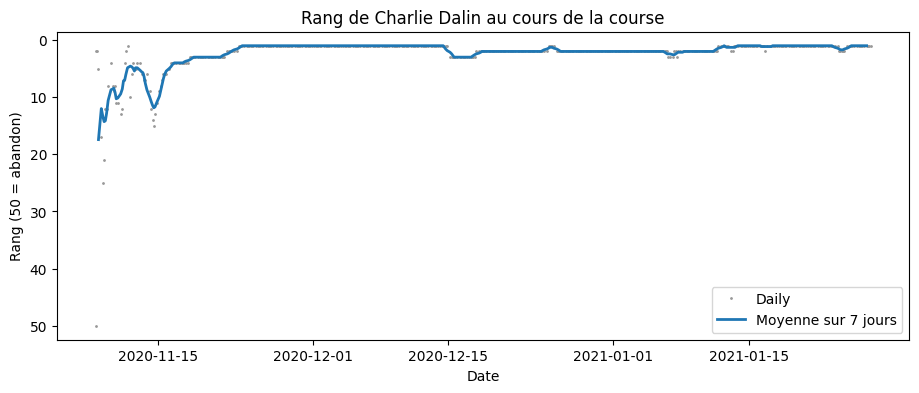

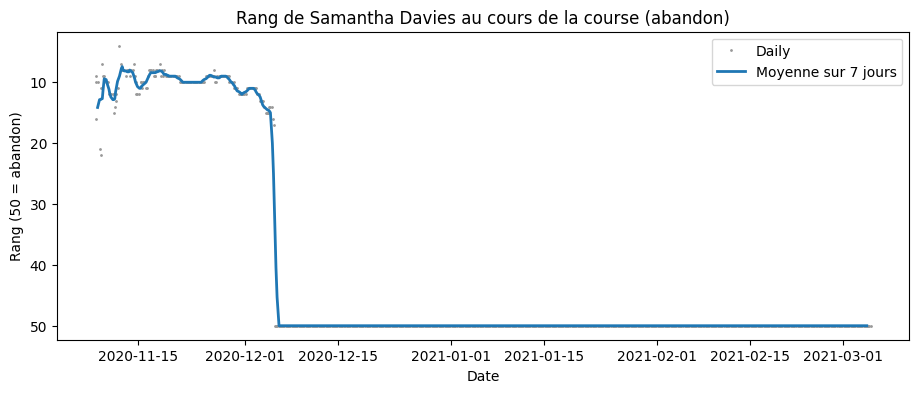

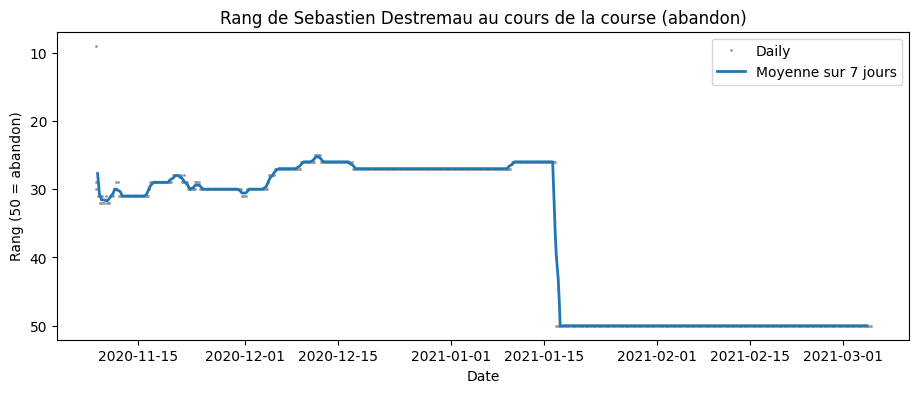

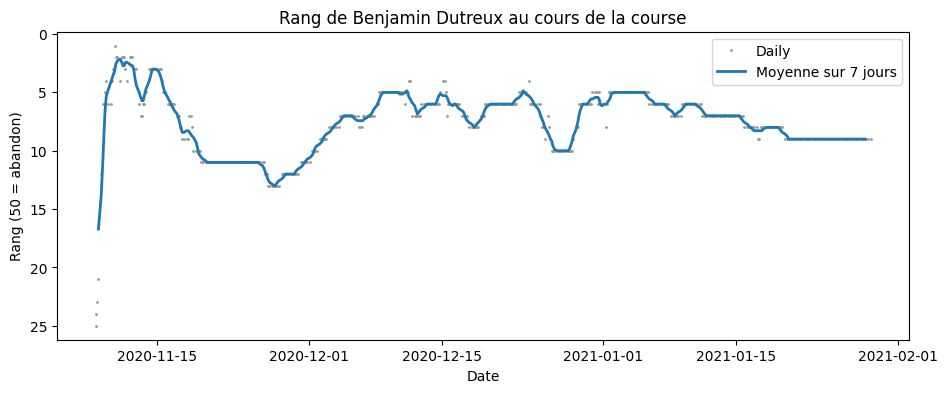

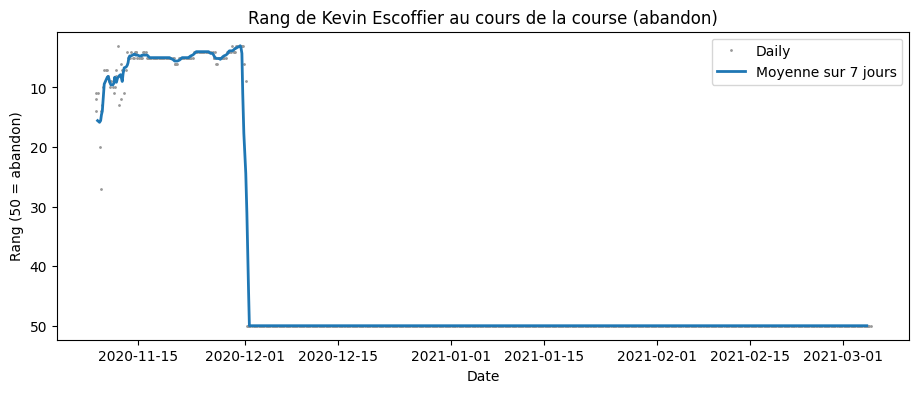

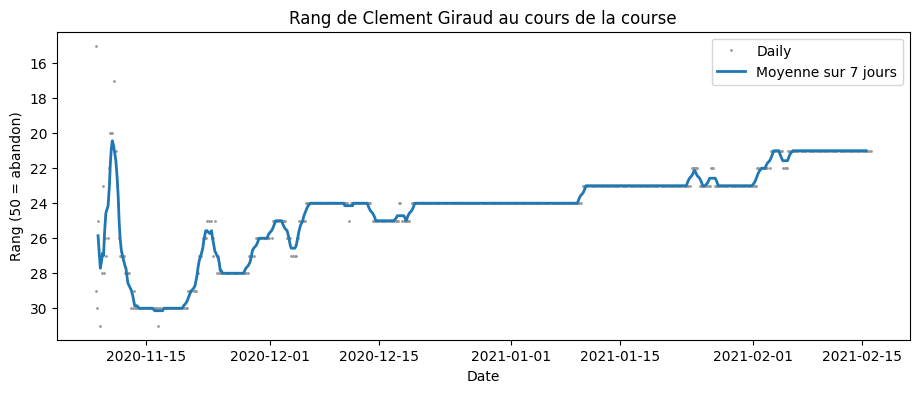

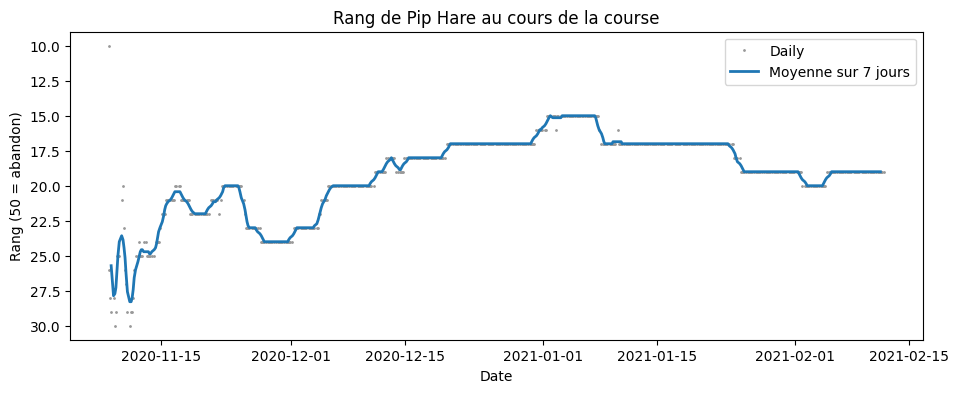

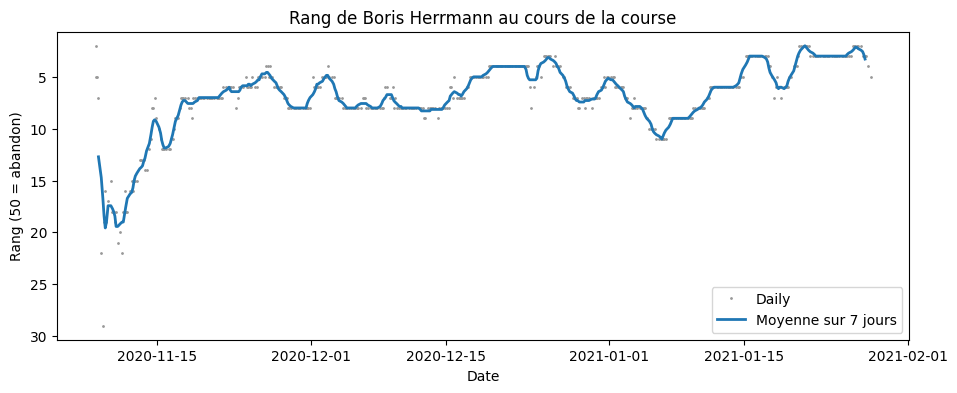

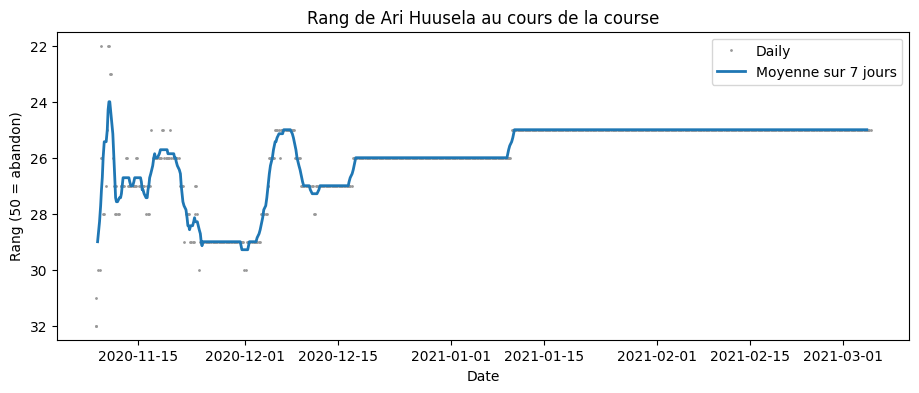

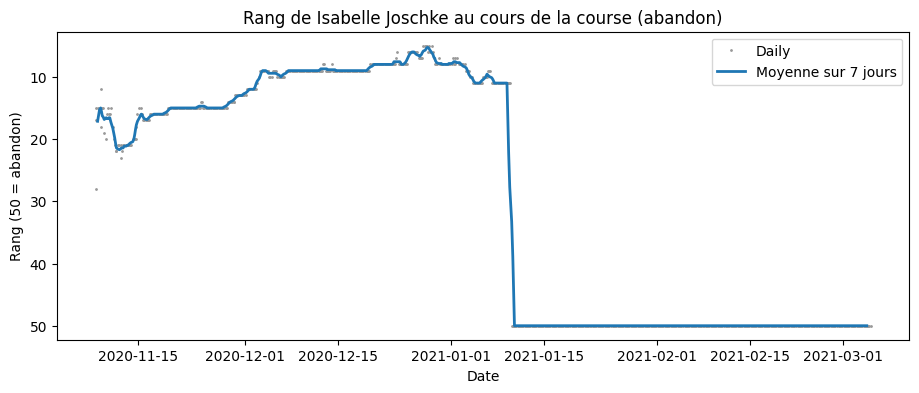

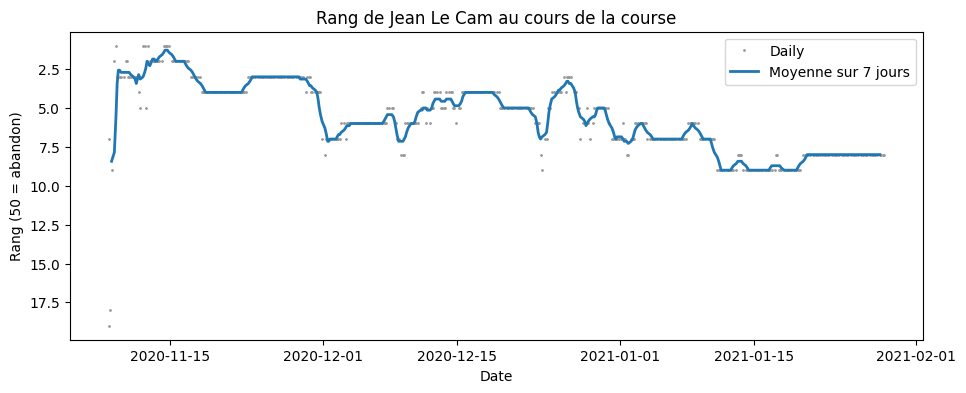

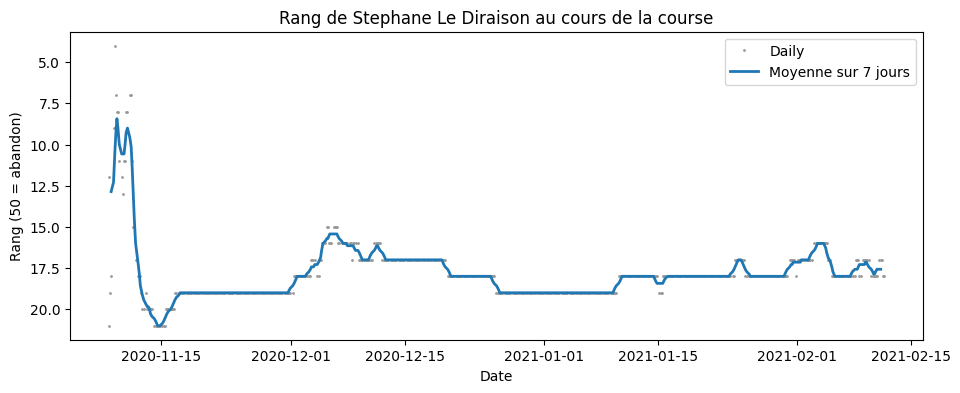

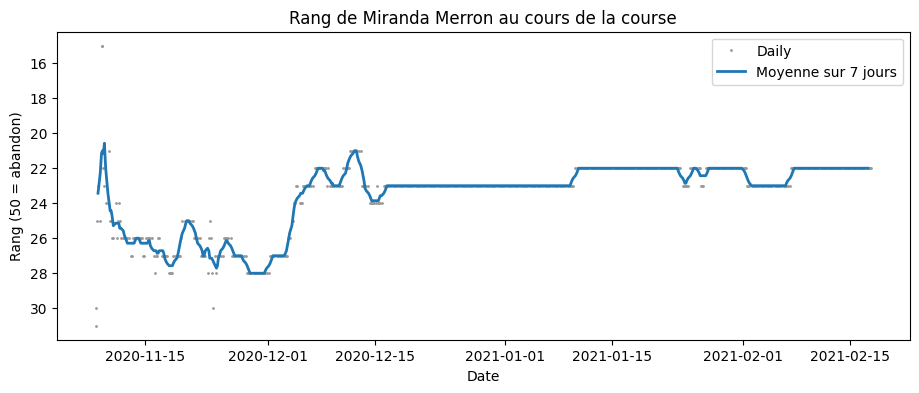

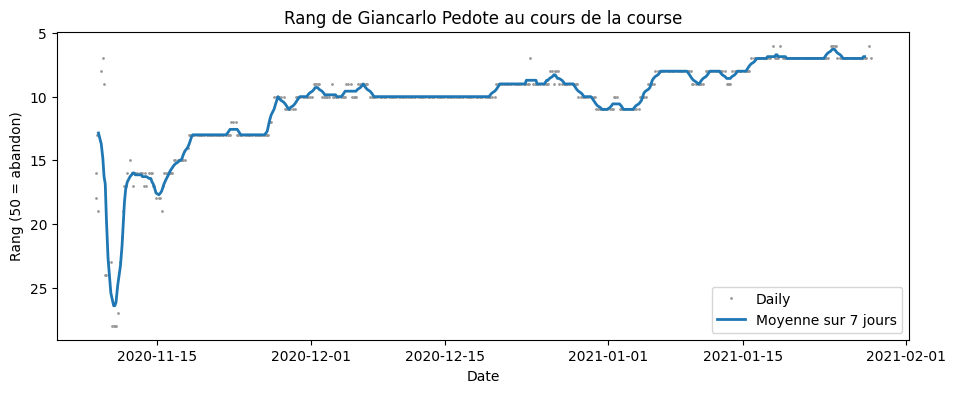

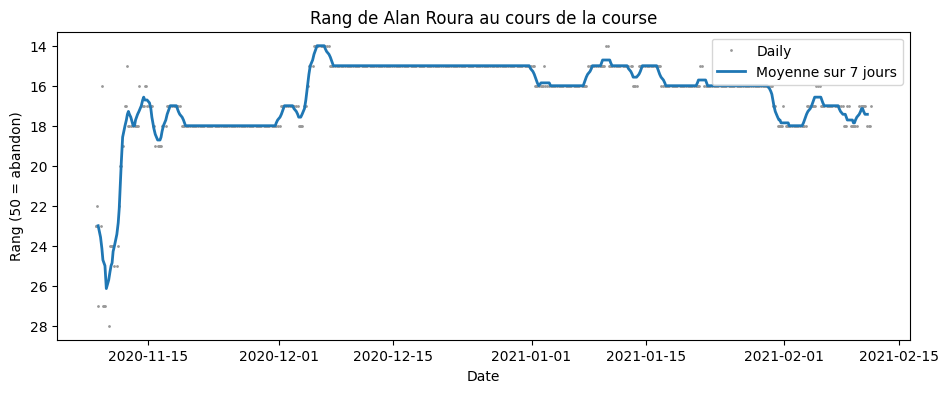

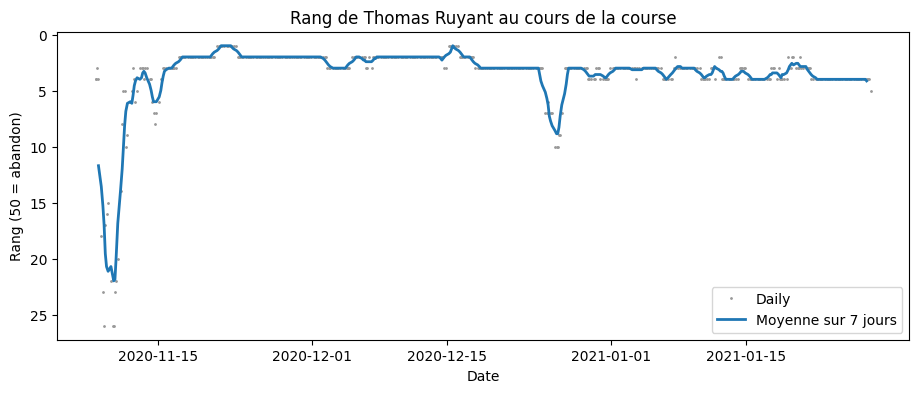

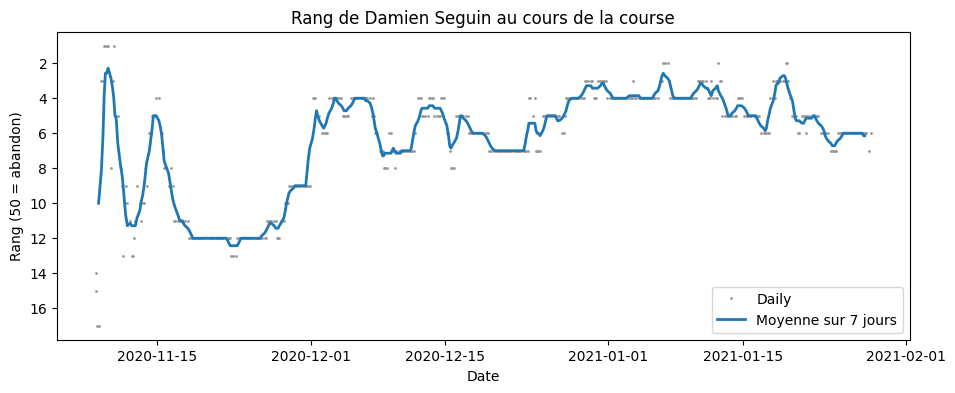

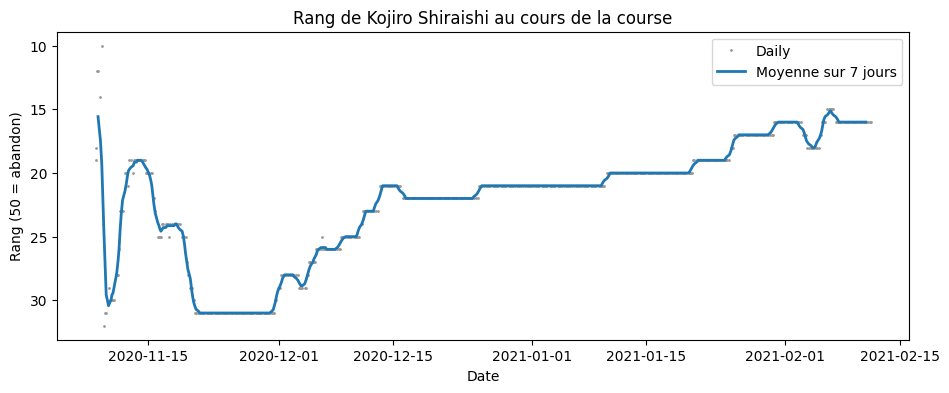

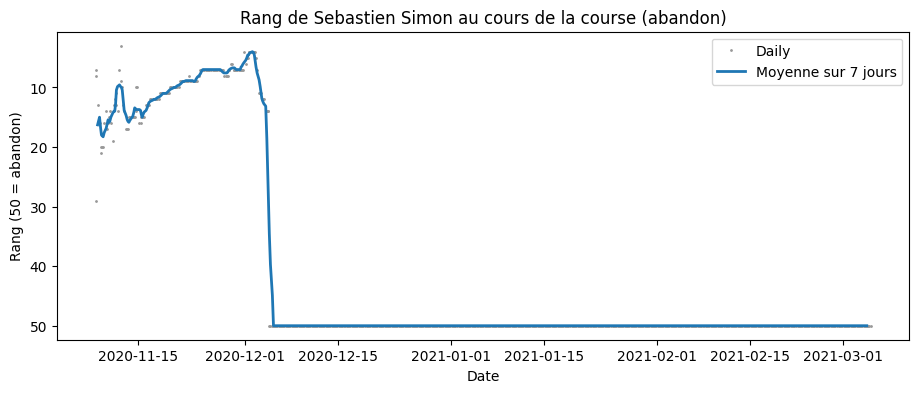

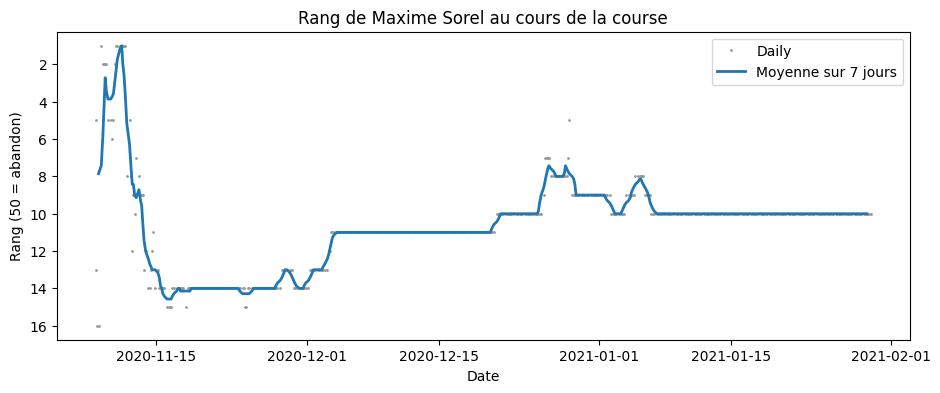

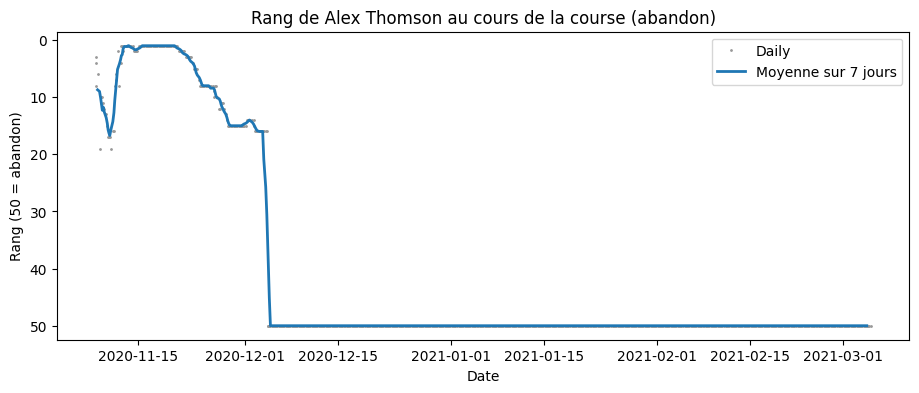

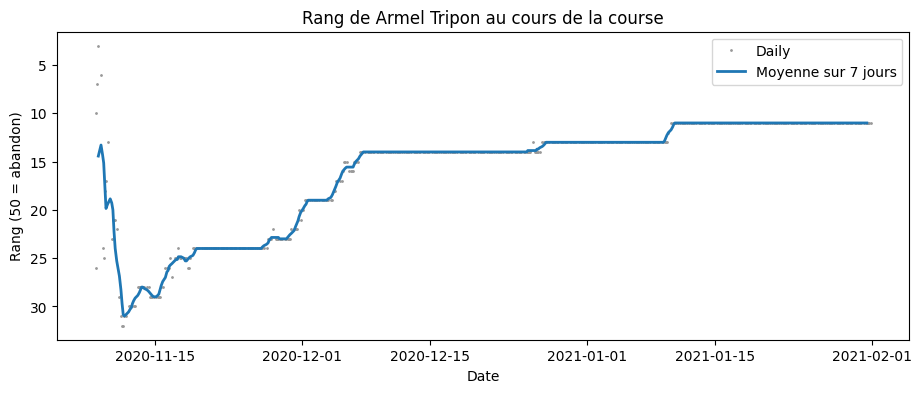

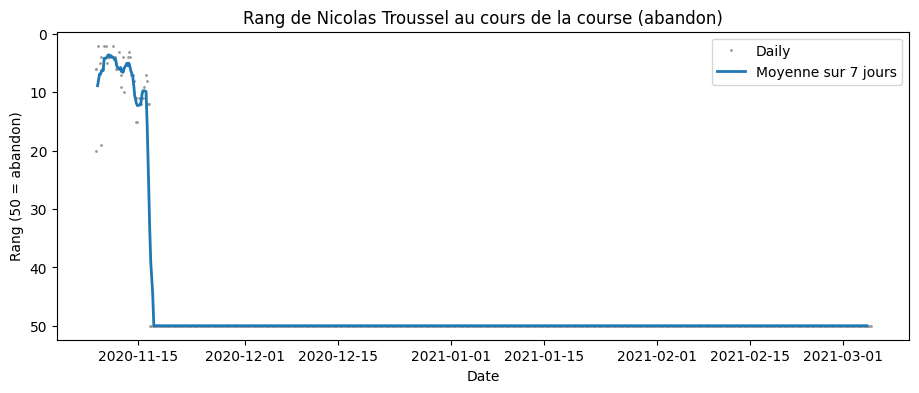

In [84]:
for skipper_name in boats_features.keys():
    df = pd.read_pickle('skippers/'+ skipper_name +'.pkl')
    df['Rang'] = df['Rang'].str.replace('RET', '50')
    df['Rang'] = df['Rang'].str.replace('NL', '50')
    #df = df[df['Rang'] != 'RET']
    #df = df[df['Rang'] != 'NL']
    if df['Rang'].empty == False:
        df['Rang'] = df['Rang'].astype(float)
        fig, ax = plt.subplots(figsize = (11,4))
        # plotting daily data
        ax.plot(df['Date'], df['Rang'], marker='.', markersize=2, color='0.6', linestyle='None', label='Daily')
        # plotting 7-day rolling data
        data_7d_rol = df['Rang'].rolling(window = 7, center = True).mean()
        ax.plot(df['Date'], data_7d_rol, linewidth=2, label='Moyenne sur 7 jours')
        ax.legend()
        ax.set_xlabel('Date')
        ax.invert_yaxis()
        ax.set_ylabel('Rang (50 = abandon)')
        # On ne prend pas en compte le début de la course où certain skipper n'était pas encore parti (NL)
        if 50.0 in list(df['Rang'])[3:]:
            ax.set_title('Rang de ' + skipper_name +' au cours de la course (abandon)')
        else:
            ax.set_title('Rang de ' + skipper_name +' au cours de la course')
        plt.show()

#### On observe que 8 skippers se sont déclaré forfait, on cherche à savoir qui sont les potentielles personnes qui ont pu les aider avant qu'il ne déclarent forfait. 

#### Obtention des skippers qui ont abandonné

In [54]:
abandon = []

for skipper_name in boats_features.keys():
    df = pd.read_pickle('skippers/'+ skipper_name +'.pkl')
    if df['Rang'].empty == False:
        if 'RET' in list(df['Rang']):
            abandon_skipper = df[['Date', 'Latitude', 'Longitude']].loc[df['Rang'] == 'RET']
            aban = [skipper_name, abandon_skipper.iloc[0][0], abandon_skipper.iloc[0][1], abandon_skipper.iloc[0][2]]
            abandon.append(aban)
abandon = pd.DataFrame(abandon, columns=['Skipper','Date','Latitude','Longitude'])
abandon = abandon.sort_values(by='Date')
abandon

Skipper                Date   Latitude   Longitude
7     Nicolas Troussel 2020-11-16 17:00:00  19.388611  -28.832222
3      Kevin Escoffier 2020-12-01 11:00:00 -40.951944    9.275833
6         Alex Thomson 2020-12-04 11:00:00 -33.920000   18.377778
5      Sebastien Simon 2020-12-04 17:00:00 -37.223611   20.415000
1      Samantha Davies 2020-12-05 14:00:00 -33.932500   18.365556
0       Fabrice Amedeo 2020-12-11 17:00:00 -37.171944   17.559167
4     Isabelle Joschke 2021-01-10 04:00:00 -44.652500  -37.125833
2  Sebastien Destremau 2021-01-16 21:00:00 -46.185556  170.603056

#### Obtention des personnes qui étaient proche de ces skippers quand ils ont abandonné

In [69]:
df = pd.read_pickle('classement/current_classement.pkl')
df = df[df['Rang'] != 'RET']
df = df[df['Rang'] != 'NL']
for i in range(len(abandon)):
    skipper = abandon['Skipper'].iloc[i]
    lat = abandon['Latitude'].iloc[i]
    long = abandon['Longitude'].iloc[i]
    lat_range = [lat-0.05, lat+0.05]
    long_range = [long-0.05, long+0.05]
    df = df[~df['Skipper / Bateau'].str.contains(skipper)]
    
    rescuers = df.loc[(df['Latitude'] > lat_range[0]) & (df['Latitude'] < lat_range[1]) & (df['Longitude'] > long_range[0]) & (df['Longitude'] < long_range[1])]
    if rescuers.empty == True:
        print("Personne n'est venu aidé", skipper, "\n")
    else:
        for i in range(len(rescuers)):
            print(rescuers['Skipper / Bateau'].iloc[i], "est venu secourir", skipper , "le", rescuers['Date'].iloc[i])
    

Personne n'est venu aidé Nicolas Troussel
Jean Le Cam / Yes We Cam ! est venu secourir Kevin Escoffier le 2020-11-30 17:00:00
Yannick Bestaven / Maitre Coq Iv est venu secourir Kevin Escoffier le 2020-11-30 21:00:00
Samantha Davies / Initiatives - Coeur est venu secourir Alex Thomson le 2020-12-05 11:00:00
Personne n'est venu aidé Sebastien Simon
Personne n'est venu aidé Samantha Davies
Personne n'est venu aidé Fabrice Amedeo
Personne n'est venu aidé Isabelle Joschke
Personne n'est venu aidé Sebastien Destremau


#### Observation du cas Jean Le Cam, Kevin Escoffier et Yannick Bestaven

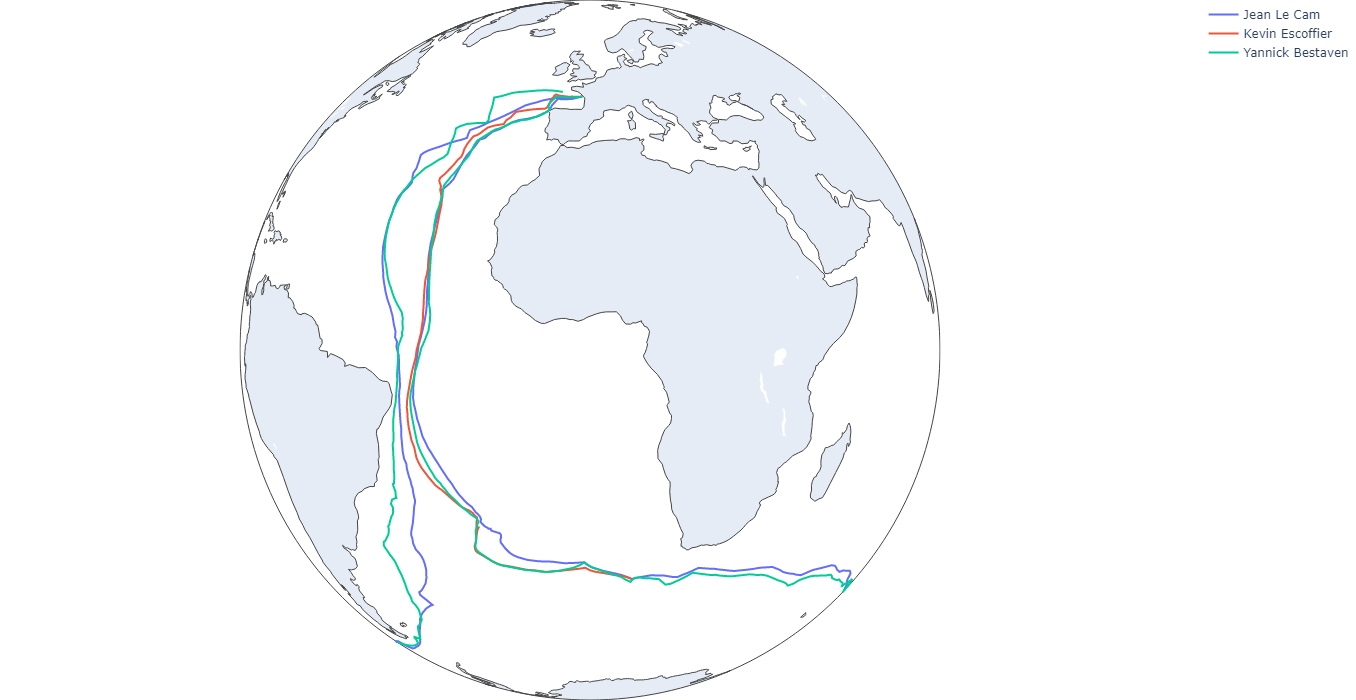

In [89]:
datas = []
skippers = ['Jean Le Cam', 'Kevin Escoffier', 'Yannick Bestaven']
for skipper_name in skippers:
    df = pd.read_pickle('skippers/'+ skipper_name +'.pkl')
    datas.append(go.Scattergeo(
        lat = list(df['Latitude']), 
        lon = list(df['Longitude']), 
        mode = 'lines', 
        line = dict(width = 2), 
        text = list(df['Date']),
        name = skipper_name
    ))

fig = go.Figure(data=datas)
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Comme on peut le voir sous le graphique ci-dessus, on observe que Jean Le Cam et Yannick Bestaven sont venu secourir Kevin Escoffier et on ainsi pu recevoir une compensation horaire. Celle-ci a notamment permis à Yannick Bestaven d'obtenir la première place du classement du Vendée Globe.

#### Observation du cas Samantha Davies et Alex Thomson

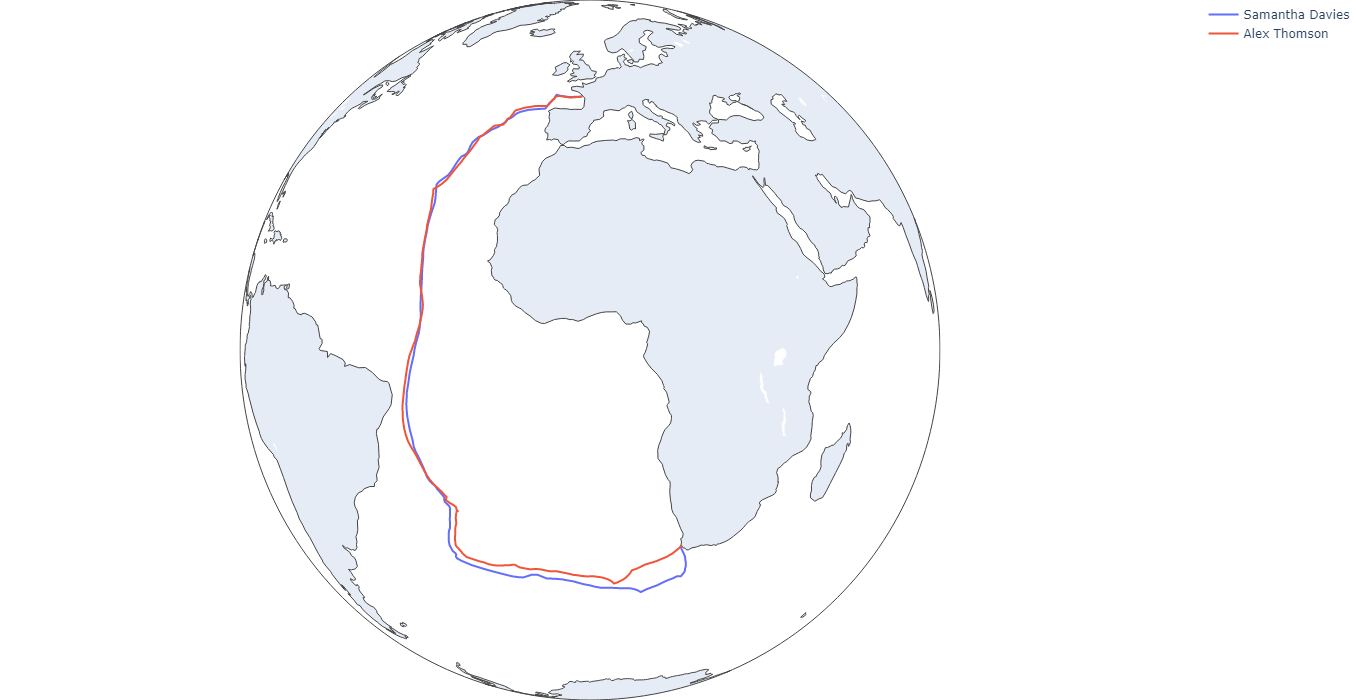

In [74]:
datas = []
skippers = ['Samantha Davies', 'Alex Thomson']
for skipper_name in skippers:
    df = pd.read_pickle('skippers/'+ skipper_name +'.pkl')
    datas.append(go.Scattergeo(
        lat = list(df['Latitude']), 
        lon = list(df['Longitude']), 
        mode = 'lines', 
        line = dict(width = 2), 
        text = list(df['Date']),
        name = skipper_name
    ))

fig = go.Figure(data=datas)
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Comme on peut le voir sous le graphique ci-dessus, on observe que Samantha Davies n'est pas venu secourir Alex Thomsom, mais a bien subit elle aussi un incident qui la forcait de déclarer forfait.